In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import os

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
Duration_Weight = {
    'Eat':1.5,
    'Sleep':2,
    'Medicine': 0.3
}
Start_Weight = {
    'Medicine': 3,
    'Eat':2,
    'Sleep':2,
}

C = 2*10**8

def sec(s):
    h, m, s = map(int, s.split(':'))
    return h*3600 + m*60 + s



In [3]:
def startTime(s):
    h, m, sec = map(int, s.split(':'))
    hrs = h + m / 60
    hrs = float('%.2f' % hrs)
    return hrs

def duration(s, f):
    s = startTime(s)
    f = startTime(f)
    m = (f - s) * 60
    m = float('%.2f' % m)
    return m

In [4]:
def fitS(x1, x2, act):
    x = abs(x2-x1)
    n = 4
    b = 3500
    C = 30
    
    score = C*exp(-(x/b)**n)
    score = score*Start_Weight[act]
    return score
    
def fitD(x1, x2,  act):
    Width = {'Sleep':2, 'Medicine': 1, 'Eat': 1, 'Bathe': 0.8}
    
    x = abs(x2-x1)
    n = 4
    b = 1000*Width[act]
    C = 30
    
    score = C*exp(-(x/b)**n)
    score = score*Duration_Weight[act]
    return score

In [5]:
eat = ['Eat', 'Eat_Breakfast', 'Eat_Lunch', 'Eat_Dinner']
sleep = ['Sleep']
med = ['Morning_Meds', 'Evening_Meds']
A = {'Eat': eat,  'Sleep': sleep, 'Medicine': med}

def fitness_day(normal, day, d):
    Score = 0
    UpdateList = [] 
    for act in A:
        day_act = day[day['Activity'].isin(A[act])] 
        normal_act = normal[normal['Activity'] == act]
        score, update = fitness_activity(normal_act, day_act, act)
        Score += score
        UpdateList.append(update)
    return Score, UpdateList

def fitness_activity(normal, day, act):

    Score = 0
    n = len(normal)
    m = len(day)
    update = {}
    
    for i in range(n):
        maxx = 0
        cluster = ''
        start = None
        dur = None
        for j in range(m):
            row1 = normal.iloc[i]
            row2 = day.iloc[j]
            
            score = fitness(row1, row2, act)
            if maxx < score:
                maxx = score
                cluster = row1['Label']
                start = startTime(row2['Start'])
                dur = duration(row2['Start'], row2['Finish'])
            
        Score += maxx
        update[cluster] = [start, dur]
   
    return Score, update
        
def fitness(row1, row2, act):
    normal_start = row1['Start']*60*60
    normal_duration = row1['Duration']*60
    
    day_start = sec(row2['Start'])
    day_finish = sec(row2['Finish'])
    day_duration = day_finish - day_start
    
    score = 0
#     score += fitD(normal_duration, day_duration, act)
#     score += fitS(normal_start, day_start, act)

    scores = fitS(normal_start, day_start, act)
    scored = fitD(normal_duration, day_duration, act)
    
#     print('Start', normal_start, day_start)
#     print('Duration', normal_duration, day_duration)
#     print()
    return scores + scored

In [12]:
def toStartDuration(A):
    X = []
    Y = []
    for i in range(len(A)):
        X.append(A[i][0])
        Y.append(A[i][1])

    return X, Y

def avg(A):
    a = sum(A)/len(A)
    a = float('%.2f'%a)
    return a

def Min(A):
    a = min(A)
    a = float('%.2f'%a)
    return a

def Max(A):
    a = max(A)
    a = float('%.2f'%a)
    return a

def processData(df):
    data = df[['Start_Time', 'Duration']]
    data = data.values.astype('float32', copy=False)
    return data

def scaleData(data):
    scaler = StandardScaler().fit(data)
    scaled_data = scaler.transform(data)
    return scaled_data

def optics(df, r, mp, act):
    data = processData(df)
    X = scaleData(data)
    
    if act != 'Eat':
        model = OPTICS( eps=r, min_cluster_size=mp, metric = 'euclidean', cluster_method='dbscan').fit(X)
    else:
         model = OPTICS(min_samples=r, min_cluster_size=mp).fit(X)
    #model = DBSCAN(eps=r, min_samples=mp, metric='euclidean').fit(X)

    if -1 in set(model.labels_):
        clusters = len(set(model.labels_)) -1
    else:
        clusters = len(set(model.labels_))


    A = []
    for i in range(clusters):
        a = data[model.labels_ == i]
        A.append(a)
    return A  

def cluster_to_list(C, activity):
    Normal = []

    for c in C:
        S, D = toStartDuration(c)
        avgS = avg(S)
        avgD = avg(D)
       
        Normal.append([activity,avgS, avgD])
    return Normal

def plot_clusters(C, title):
    colors = 10*['red', 'orange', 'purple', 'green', 'blue', 'black']
    c = 0
    fig = plt.figure()
    plt.title(title)
    for c in C:
        
        X, Y = toStartDuration(c)
        if len(X) > 0:
            plt.scatter(X, Y)
            c += 1


def update_adaptive_normal(dataset):
    path = '..\CASAS_DATA\HH' + dataset + r'\Activities\Adaptive_Normal.csv'
    new_data = []
    df = pd.read_csv(path)
    l = len(df)
    
    for i in range(l):
        row = df.iloc[i]
        act = row['Activity']
        label = row['Label']
        
        cluster_path = '..\CASAS_DATA\HH' + dataset + '\\Activities\\Clusters\\' + label + '.csv'
        cluster = pd.read_csv(cluster_path)
        
        Start = cluster['Start']
        Dur = cluster['Duration']
        
        new_data.append([act, label, avg(Start), avg(Dur), Min(Start), Max(Start), Min(Dur), Max(Dur)])
    cols = ['Activity','Label','Start','Duration','min_start','max_start','min_dur','max_dur']
    new_df = pd.DataFrame(new_data, columns=cols)
    new_df.to_csv(path, index=False)
    

def update_dataset(dataset, new_data, rate):
    dataset_path = '..\CASAS_DATA\HH' + dataset + '\\Activities\\Clusters\\'
    for activity in new_data:
        for label in activity:
            if label != '':
                start, dur = activity[label]
                read_path = dataset_path + label + r'.csv'
                df = pd.read_csv(read_path)
                l = len(df)
                for x in range(rate):
                    df.loc[l+x] = [start, dur]
                df.to_csv(read_path, index=False)
                #print(read_path)
                
    update_adaptive_normal(dataset)
    
        

In [16]:
def get_fitness_plot(trained, test, rate):
    trained_dataset = pd.read_csv(r'..\CASAS_DATA\HH' + trained + r'\Activities\Adaptive_Normal.csv')
    
    count = 1
    Fitness_Days = []
    Fitness_Score = []
    change = []
    
    for dataset in test:
        Day_start = 1
        Day_end = 0
        
        if trained == dataset:
            dirc = r'..\CASAS_DATA\HH' + dataset + r'\test_data'
            Day_end = len(os.listdir(dirc))
        else:
            dirc = r'..\CASAS_DATA\HH' + dataset + r'\filling'
            Day_end = len(os.listdir(dirc))

        adaption_rate = rate
        
        for day in range(Day_start, Day_end+1):
            read_path = ''
            
            if trained == dataset:
                read_path = r'..\CASAS_DATA\HH' + dataset + r'\test_data\Day' + str(day) + r'.csv'
            else:
                read_path = r'..\CASAS_DATA\HH' + dataset + r'\filling\Day' + str(day) + r'.csv'
            
            trained_dataset = pd.read_csv(r'..\CASAS_DATA\HH' + trained + r'\Activities\Adaptive_Normal.csv')
            day_df = pd.read_csv(read_path)
            fitness_score, update = fitness_day(trained_dataset, day_df, day)
            fs = float('%.1f'%fitness_score)
           
            threshhold = 400
            if dataset != trained and fs < threshhold:
                #print(update)
                update_dataset(trained, update, adaption_rate)
                if adaption_rate > 2:
                    adaption_rate -= 2
                else:
                    adaption_rate =  1
          
            Fitness_Days.append(count)
            count += 1
            Fitness_Score.append(fs)
          
        change.append(count)
    
    fig = plt.figure(figsize=(15,8))
    plt.plot(Fitness_Days, Fitness_Score, marker = 'o', mfc = 'r')
    title = trained + ' Trained  | ' + ' Testing on ' + ', '.join(test)
    plt.title(title,fontdict = {'fontsize' : 20})
    plt.xlabel('Days',fontdict = {'fontsize' : 13})
    plt.ylabel('Fitness Score', fontdict = {'fontsize' : 13})
    
    for c in change:
        plt.plot([c,c], [0, 500], color='orange', linestyle='--', linewidth=2)
    

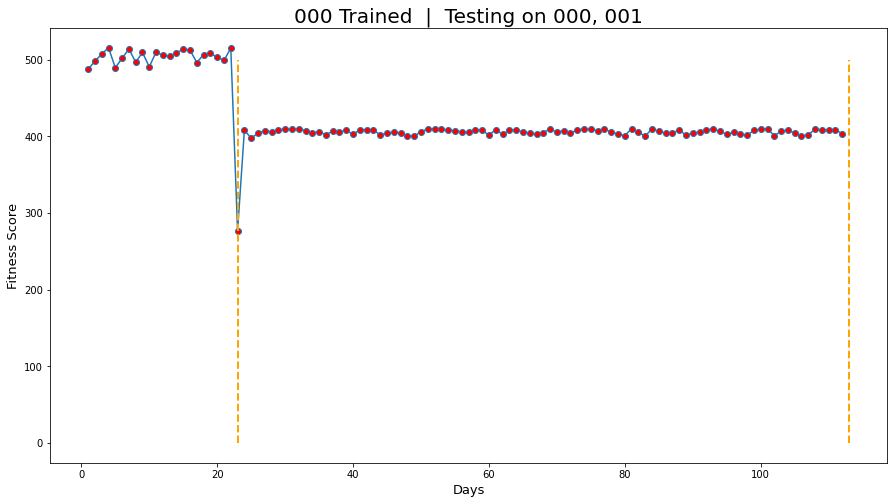

In [17]:
readpath = r'..\CASAS_DATA\HH000\Activities\Normal.csv'
savepath = r'..\CASAS_DATA\HH000\Activities\Adaptive_Normal.csv'

df = pd.read_csv(readpath)
df.to_csv(savepath, index = False)
get_fitness_plot('000', [ '000', '001'], 3) #lEARNING RATE  = 3

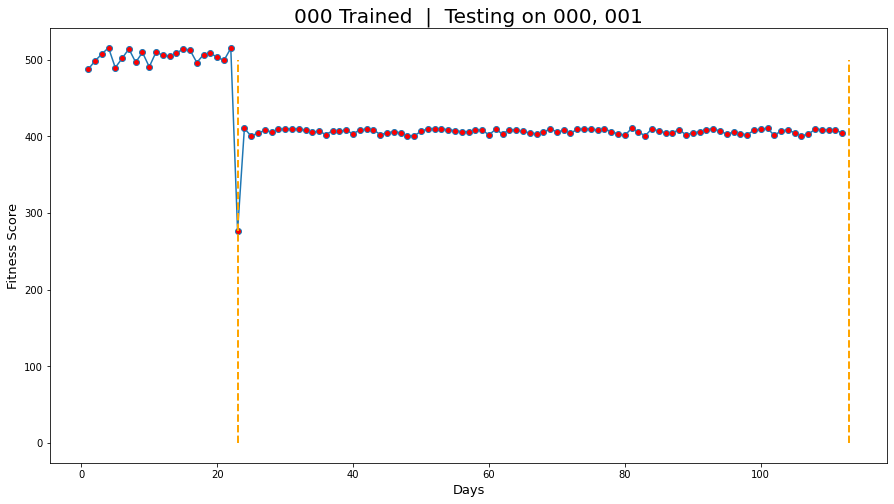

In [18]:
readpath = r'..\CASAS_DATA\HH000\Activities\Normal.csv'
savepath = r'..\CASAS_DATA\HH000\Activities\Adaptive_Normal.csv'

df = pd.read_csv(readpath)
df.to_csv(savepath, index = False)
get_fitness_plot('000', [ '000', '001'], 1) #lEARNING RATE  = 1

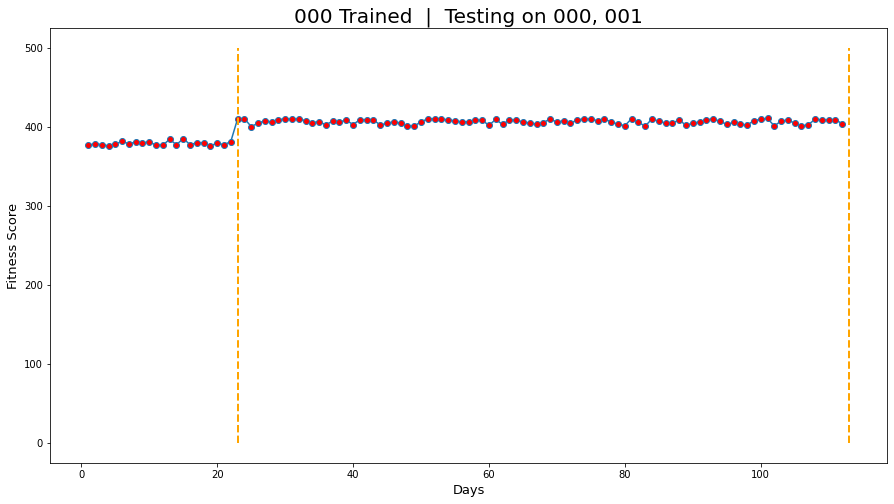

In [19]:
readpath = r'..\CASAS_DATA\HH000\Activities\Normal.csv'
savepath = r'..\CASAS_DATA\HH000\Activities\Adaptive_Normal.csv'

df = pd.read_csv(readpath)
#df.to_csv(savepath, index = False)
get_fitness_plot('000', [ '000', '001'], 2) #lEARNING RATE  = 2

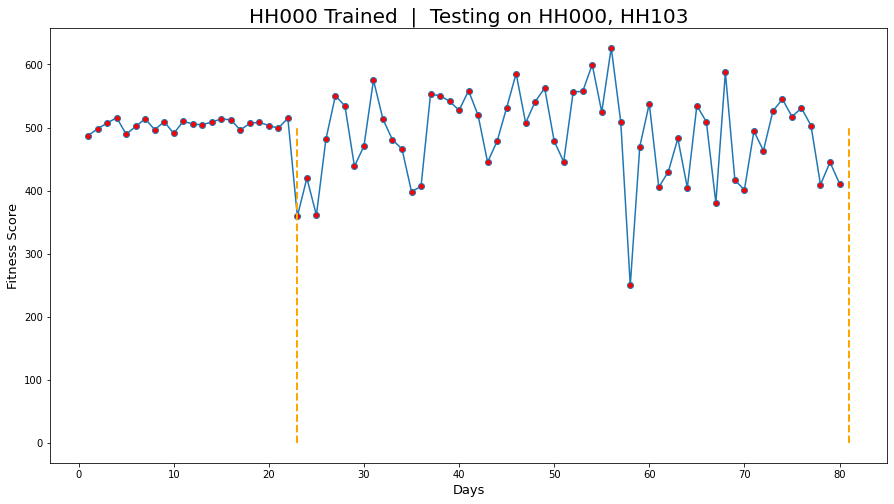

In [11]:
readpath = r'..\CASAS_DATA\HH000\Activities\Normal.csv'
savepath = r'..\CASAS_DATA\HH000\Activities\Adaptive_Normal.csv'

df = pd.read_csv(readpath)
df.to_csv(savepath, index = False)
get_fitness_plot('000', [ '000', '103'],4)

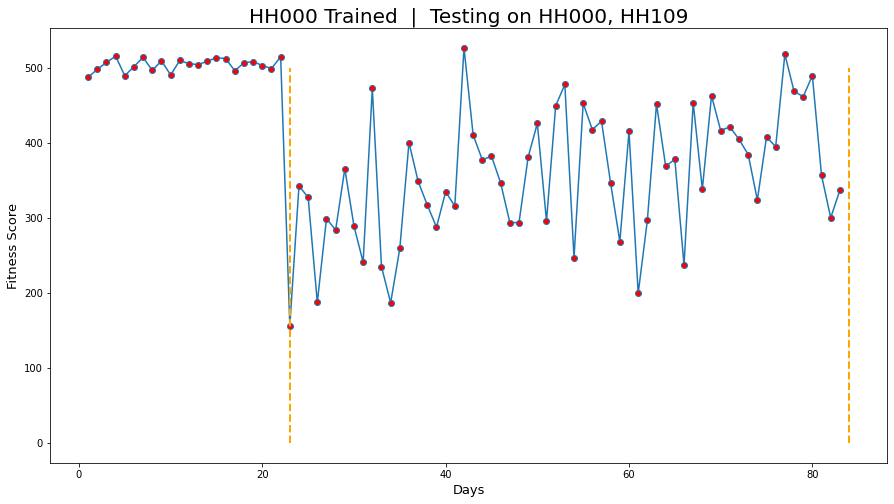

In [30]:
readpath = r'..\CASAS_DATA\HH000\Activities\Normal.csv'
savepath = r'..\CASAS_DATA\HH000\Activities\Adaptive_Normal.csv'

df = pd.read_csv(readpath)
df.to_csv(savepath, index = False)
get_fitness_plot('000', [ '000', '109'],4)

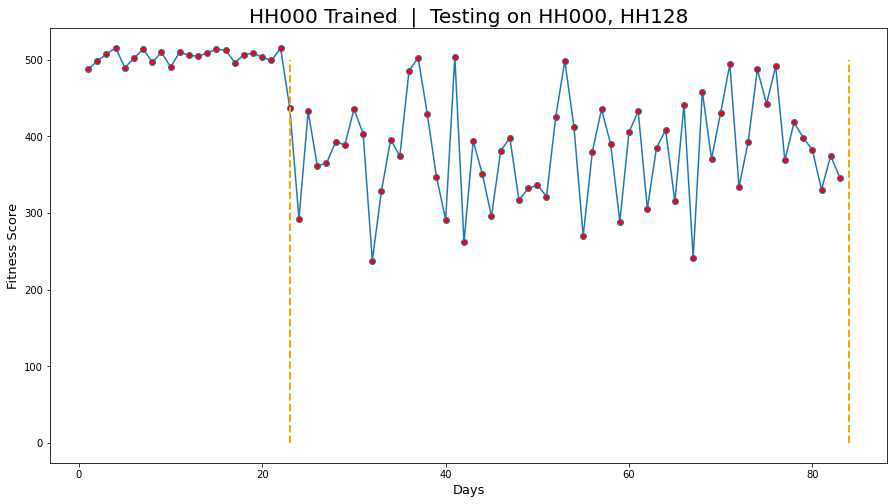

In [31]:
readpath = r'..\CASAS_DATA\HH000\Activities\Normal.csv'
savepath = r'..\CASAS_DATA\HH000\Activities\Adaptive_Normal.csv'

df = pd.read_csv(readpath)
df.to_csv(savepath, index = False)
get_fitness_plot('000', [ '000', '128'],3)